#  Part2. 종목별 주가 정보

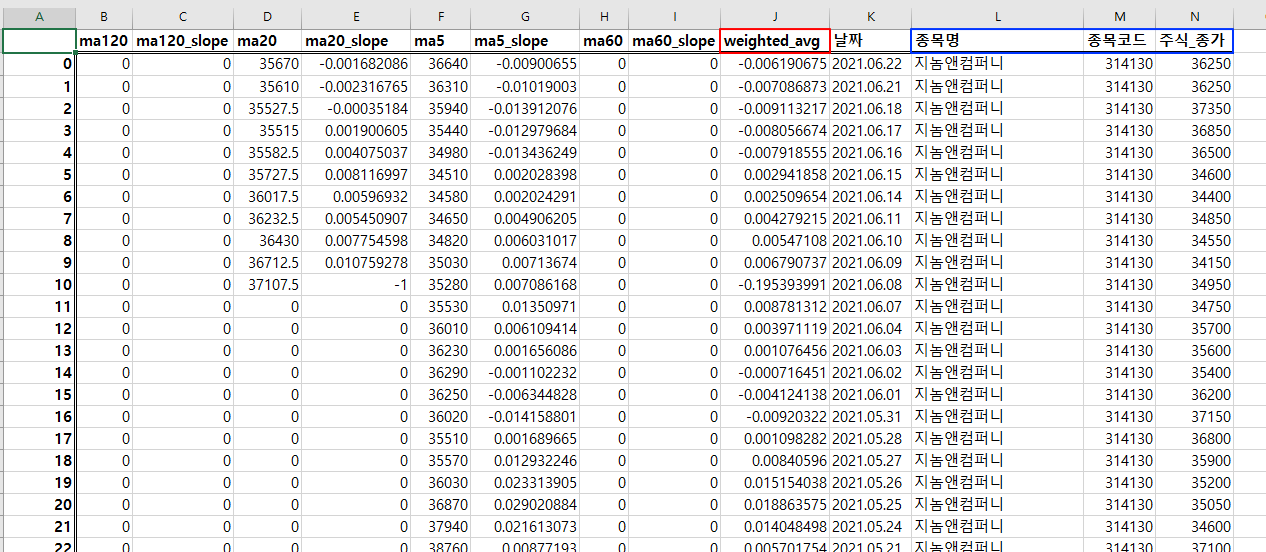

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime

In [22]:
# usecols 뽑을 데이터 지정하는 코드, converters 종목코드 str으로 바꿔주는 코드
### 종목코드 앞자리가 0이므로 스트링으로 지정해주지않으면 0이 사라짐 ###

# 상장회사 목록
df2 = pd.read_csv('Dart_codelist_last30_2.csv', usecols = ['종목명','종목코드','기업코드','수정일'], converters={'종목코드':str,'기업코드':str})
df2

,종목명,종목코드,기업코드,수정일
0,지놈앤컴퍼니,314130,01276026,20210216
1,웹젠,069080,00405320,20210215
2,우리넷,115440,00664048,20210217
3,마이크로디지탈,305090,01267967,20210217
4,나노,187790,00994994,20210216
...,...,...,...,...
1970,컨버즈,109070,00753643,20210513
1971,텔라움,047730,00304401,20210506
1972,뉴파워프라즈마,144960,00521390,20210602
1973,에이디테크놀로지,200710,00657002,20210602


In [23]:
## 종목코드의 기업명 불러낼 dict 만들기
## ∇여기부터

corp_dict = {}

for i in range(len(df2['종목코드'])):  # 아래 크롤링에 포함된 함수에 기업명 컬럼을 추가하기 위해 dict 형태로 전처리
    corp_dict[df2.loc[i]['종목코드']] = str(df2.loc[i]['종목명'])
corp_dict

{'314130': '지놈앤컴퍼니',
 '069080': '웹젠',
 '115440': '우리넷',
 '305090': '마이크로디지탈',
 '187790': '나노',
 '066910': '손오공',
 '042600': '새로닉스',
 '051380': '피씨디렉트',
 '160600': '이큐셀',
 '225430': '케이엠제약',
 '331520': '교보9호스팩',
 '086220': '네추럴FNP',
 '215100': '로보로보',
 '069730': 'DSR제강',
 '355150': '교보10호기업인수목적',
 '339950': '아이비김영',
 '233250': '메디안디노스틱',
 '357250': '미래에셋맵스리츠',
 '101680': '한국정밀기계',
 '318410': '비비씨',
 '122350': '삼기',
 '245450': '씨앤에스링크',
 '033270': '유나이티드',
 '263860': '지니언스',
 '033540': '파라텍',
 '015360': '예스코홀딩스',
 '025320': '시노펙스',
 '012690': '모나리자',
 '004870': '티웨이홀딩스',
 '264660': '씨앤지하이테크',
 '004450': '삼화왕관',
 '035150': '백산',
 '239890': '피엔에이치테크',
 '215050': '비엔디생활건강',
 '003380': '하림지주',
 '096630': '에스코넥',
 '001360': '삼성제약',
 '133820': '화인베스틸',
 '006250': '극동전선',
 '214270': '퓨쳐스트림네트웍스',
 '023460': 'CNH',
 '033020': '세아메탈',
 '052710': '아모텍',
 '065570': '삼영이엔씨',
 '086710': '선진뷰티사이언스',
 '285130': 'SK케미칼',
 '029780': '삼성카드',
 '290510': '코리아센터',
 '084690': '대상홀딩스',
 '032540': 'TJ미디어',
 '196

In [24]:
### 
com_code = df2['종목코드']
com_code

0       314130
1       069080
2       115440
3       305090
4       187790
         ...  
1970    109070
1971    047730
1972    144960
1973    200710
1974    900140
Name: 종목코드, Length: 1975, dtype: object

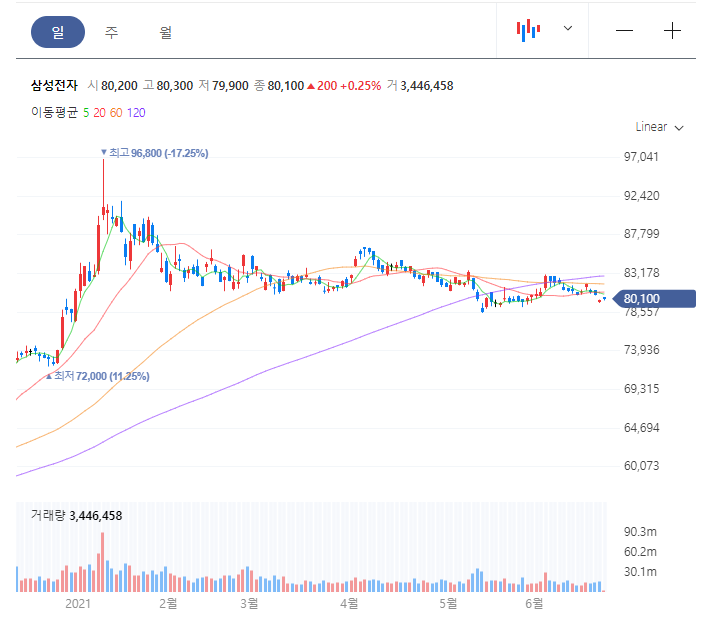

In [1]:
# lst = [1,2,3,4,5,6,7]
# temp_rolling = pd.DataFrame(lst)  ## 1번. 시리즈 인덱스 저장하기 
# # temp_rolling
# temp_rolling = temp_rolling.iloc[::-1]  ## 2번. 컬럼 뒤집기 ## 
# temp_rolling
# temp_rolling = temp_rolling.rolling(window=5).mean() ## 3번. rolling 이라는 함수를
# # temp_rolling
# temp_rolling = temp_rolling.iloc[::-1]
# temp_rolling

In [9]:
# 이동평균선을 구하기 위해 전처리 함수 
def reverse_rolling(series, windows_):

    # 시리즈 인덱스 저장하기
    index = series.index
    # 컬럼 뒤집기
    series = pd.DataFrame(series.iloc[::-1])
    # 컬럼뒤집어서 이동평균
    series = series.rolling(window = int(windows_)).mean() 
    # 컬럼 다시 뒤집기  
    series = series.iloc[::-1]  
    # 저장했던 index 다시 집어넣기
    series['index'] = index
    # index 재설정하기
    series = series.set_index('index')

    return series

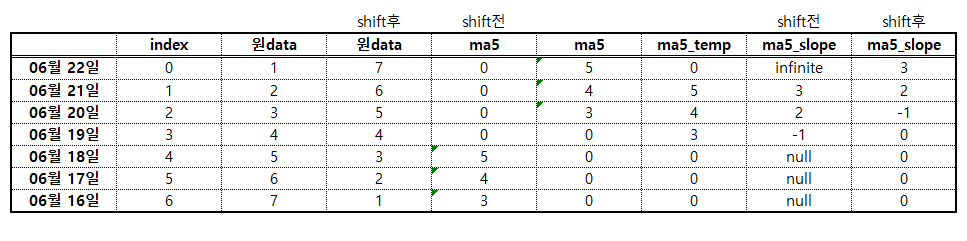

In [25]:
# 종목코드 기준으로 df별로 돌릴거
# 5일 / 20일 / 60일 / 120일 이동평균선 구하기 함수

def cross_score(df):

    df['ma5']=reverse_rolling(df['주식_종가'],5).fillna(value=0)
    df['ma5_temp'] = df['ma5'].shift(fill_value=0).fillna(value=0) #  ma5 기울기(slope)를 구하기 위해 임시적으로 값을 하나씩 내리고 빈칸을 0으로 채우기
    df['ma5_slope'] = pd.to_numeric(((df['ma5']-df['ma5_temp'])/(df['ma5_temp']))\   #1. 기울기를 계산하고
            .replace(np.inf,"0").fillna(value=0)).shift(periods=-1,fill_value=0)     #2. 무한대값과 nul값을 0으로 변환
# pd.to_numeric(df['ma5_slope']) str->int

## 20일 기준 이동평균
    df['ma20']=reverse_rolling(df['주식_종가'],20).fillna(value=0)
    df['ma20_temp'] = df['ma20'].shift(fill_value=0).fillna(value=0)
    df['ma20_slope']=pd.to_numeric(((df['ma20']-df['ma20_temp'])/(df['ma20_temp']))\
            .replace(np.inf,"0").fillna(value=0)).shift(periods=-1,fill_value=0)

## 60일 기준 이동평균
    df['ma60']=reverse_rolling(df['주식_종가'],60).fillna(value=0)
    df['ma60_temp'] = df['ma60'].shift(fill_value=0).fillna(value=0)
    df['ma60_slope'] = pd.to_numeric(((df['ma60']-df['ma60_temp'])/(df['ma60_temp']))\
            .replace(np.inf,"0").fillna(value=0)).shift(periods=-1,fill_value=0)

## 120일 기준 이동평균
    df['ma120']=reverse_rolling(df['주식_종가'],120).fillna(value=0)
    df['ma120_temp'] = df['ma120'].shift(fill_value=0).fillna(value=0)
    df['ma120_slope']=pd.to_numeric(((df['ma120']-df['ma120_temp'])/(df['ma120_temp']))\
            .replace(np.inf,"0").fillna(value=0)).shift(periods=-1,fill_value=0)
    
## 이동평균선 기준 scoring
## 향후 과제로 해당 weight를 찾는걸 해도 될듯.
    df['weighted_avg']= 0.65 * df['ma5_slope']\
                        + 0.2 * df['ma20_slope'] \
                        + 0.1 * df['ma60_slope'] \
                        + 0.05 * df['ma120_slope']

    del(df['ma20_temp'])
    del(df['ma5_temp'])
    del(df['ma60_temp'])
    del(df['ma120_temp'])
    
    

    return df

SyntaxError: unexpected character after line continuation character (<ipython-input-25-acee574c7680>, line 8)

# 데이터분석을 위한 전체 데이터프레임 추출 (35만개 데이터)

In [7]:
#############최종본
########빈리스트 만들기##########
df_list = []

###############################

df_total = pd.DataFrame()
temp_df = pd.DataFrame()


###################
# step1. 원하는 시세 페이지 범위 정하기 

page_number_lst = []  
for i in range(18):     # 원하는 페이지수만큼 range의 파라미터 설정 
    page_number_lst.append(i+1)

# step2. 네이버 증권의 시세 페이지에서 종가 및 날짜 데이터 크롤링해서, 기업별 종목코드로 DataFrmae 만들기     

for code in com_code:
    df = pd.DataFrame()   # 빈 DataFrame 만들기 (종목별로 DataFrmae 값을 넣기 위한 틀)
    list_date = []        # 리스트 초기화 
    list_endprice = []
    corp_total = []
    corp_name = []
    for _page in page_number_lst: # 1페이지부터 n페이지까지 크롤링  (Step1 참조.)

        url_head = 'https://finance.naver.com/item/sise_day.nhn?code={}&page={}'.format(code,_page)  # 종목코드와 페이지를 넣는 url 생성
        headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}
        web = requests.get(url_head, headers = headers).content #자료 요청
        soup = BeautifulSoup( web, 'html.parser') # html 파싱

        for tr in soup.find('table').find_all('tr'): # 일별시세 웹에서 ['날짜'.'종가','전일비'.. ] 행 크롤링, (table 태그안에 tr태그의 텍스트) 이미지참조.
            try:
                if len(tr.find_all("td")[0].get_text()) != 10: # 날짜가 비워진 셀은 패스 / 
                    pass
                else:
                    if tr.find_all("td")[0].get_text() in list_date and int(tr.find_all("td")[0].get_text()[:4]) < 2021: # 동일한 날짜가 기존에 있었는지 체크 (중복 페이지 예외처리)
                        break
                    else:
                        list_date.append(tr.find_all("td")[0].get_text())   # 날짜 데이터 삽입
                        list_endprice.append(tr.find_all('td')[1].get_text())  # 종가 데이터 삽입
                        corp_total.append(code)  # 종목 코드 삽입
                        corp_name.append(corp_dict[code]) # 기업명 삽입
            except:
                pass
    for i in range(len(list_endprice)):
        list_endprice[i] = list_endprice[i].replace(",","")   # 추후 계산을 위해 값의 쉼표(,) 제거
        
#     list_endprice = list(map(int,list_endprice))  #실행시 오류가 나서 제외

    df['날짜'] = list_date               # 날짜 컬럼에 날짜 Valuse 삽입
    df['주식_종가'] = list_endprice      # 주식종가 컬럼에 종가 Valuse 삽입
    df['종목코드'] = corp_total          # 종목코드 컬럼에 코드 Valuse 삽입
    df['종목명'] = corp_name             # 종목명 컬럼에 기업명 Valuse 삽입
    
##################  globals 함수 -> 전역변수로 만들어 주기 ########################     
    globals()['df_{}'.format(code)]= cross_score(df[df['종목코드']==code]) # 1.위에서 만든 이동평균선을 만든느 함수(cross_score)와 합쳐서 Df만들고 
                                                                          # 2.Globals() 함수로 전역변수로 변환해서, 추후 함수 파라미터(변수)로 활용
    temp_df = globals()['df_{}'.format(code)]  
    df_total = pd.concat([df_total,temp_df],ignore_index=True, sort=True) # 모든 기업들의 DataFrame을 하나의 Data Frame으로 합치기
#     df_list.append(['df_{}'.format(code)])   # 만들어진 기업별 df명 리스트화 (확인용)
    
################# for문 함수 종료 ####################


<hr style="border-color:yellow; border-width:3px">

In [8]:
df_total.to_csv('Part2_output.csv', encoding = 'euc-kr')

NameError: name 'df_total' is not defined

In [8]:
df_total[df_total['weighted_avg']>0]


<hr style="border-color:red; border-width:3px">
<hr style="border-color:red; border-width:3px">


# Part3 Data Merge (Part1 + Part2)

In [9]:
# 1일 ->01일
month_ =''
day_ = ''
if len(str(datetime.today().month)) ==1:
    month_ = str('0'+str(datetime.today().month))
else:
    pass
if len(str(datetime.today().day)) == 1:
    day_ = str('0'+str(datetime.today().day))
else:
    day_=str(datetime.today().day)

In [11]:
today_ = str(datetime.today().year)+'.'+str(month_)+'.'+str(day_)

In [7]:
df_today_total = df_total[df_total['날짜']==today_]
df_today_total

NameError: name 'df_total' is not defined

## 금일 기준_시가총액 컬럼 추가

In [6]:
df_code = df_today_total['종목코드']
df_code

NameError: name 'df_today_total' is not defined

In [14]:
headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}
head_url = "https://finance.naver.com/item/main.nhn?code="

market_cap_list = []

for code in df_code:
    web = requests.get(head_url + code, headers = headers).content #자료 요청
    soup = BeautifulSoup( web, 'html.parser') # html 파싱

    market_cap = soup.find('em',{"id":"_market_sum"})\
    .get_text().strip().replace("\n","").replace("\t","").replace(",","") #시가총액 크롤링
    market_cap_int = int(market_cap.replace("조",""))*100000000 #1조 3456 =>13456
    market_cap_list.append(market_cap_int)
#         print(market_cap_list,"True")  # 검증용

        
market_cap_list
        
df_today_total['시가총액'] = market_cap_list
df_today_total

[489500000000,
 139900000000,
 80900000000,
 172500000000,
 48200000000,
 81800000000,
 132300000000,
 88600000000,
 18600000000,
 83500000000,
 8400000000,
 22200000000,
 78800000000,
 95800000000,
 11300000000,
 127200000000,
 61100000000,
 103100000000,
 12100000000,
 103700000000,
 161400000000,
 3600000000,
 849600000000,
 70500000000,
 134800000000,
 231300000000,
 264400000000,
 200800000000,
 119700000000,
 111400000000,
 99700000000,
 217100000000,
 165300000000,
 3900000000,
 946500000000,
 162100000000,
 588300000000,
 88200000000,
 157700000000,
 130900000000,
 292800000000,
 87000000000,
 115600000000,
 3120000000000,
 3950800000000,
 615700000000,
 416400000000,
 82100000000,
 72600000000,
 170500000000,
 288400000000,
 38000000000,
 8100000000,
 8700000000,
 370800000000,
 386600000000,
 106500000000,
 668700000000,
 179000000000,
 63700000000,
 441300000000,
 81800000000,
 1439000000000,
 504500000000,
 189600000000,
 4200000000,
 593300000000,
 182500000000,
 101000000

In [77]:
df_part1 = pd.read_csv('JM_2021_1Q.csv',encoding='utf-8')

In [208]:
df_part3_by_date = df_total[(df_total['날짜']=='2021.06.21')|(df_total['날짜']=='2021.03.31')]
# 종목명, 종목코드, 주식_종가,[주식_등락]
df_part3_pre = df_part3_by_date[['종목코드','주식_종가','날짜','weighted_avg']]
df_part3_pre = pd.merge(df_part3_pre,df_code_and_corp,how='inner',on='종목코드')

In [213]:
df_part3_pre

,종목코드,주식_종가,날짜,weighted_avg,종목명,시가총액
0,314130,36250,2021.06.21,-0.006088,지놈앤컴퍼니,489500000000
1,314130,51000,2021.03.31,0.014884,지놈앤컴퍼니,489500000000
2,069080,31700,2021.06.21,0.003304,웹젠,139900000000
3,069080,41450,2021.03.31,0.003919,웹젠,139900000000
4,115440,8910,2021.06.21,-0.003271,우리넷,80900000000
5,115440,8610,2021.03.31,0.001824,우리넷,80900000000
6,305090,23800,2021.06.21,0.007271,마이크로디지탈,172500000000
7,305090,18550,2021.03.31,0.004556,마이크로디지탈,172500000000
8,187790,1830,2021.06.21,-0.001435,나노,48200000000
9,187790,1515,2021.03.31,-0.002602,나노,48200000000


In [207]:
company_counts = list(dict(df_part3_pre['종목코드'].value_counts()).items())
company_once = []

for company in company_counts:
    if company[1] == 1:
        company_once.append(company[0])
        
company_checker = []

for row_name, row in df_part3_pre.iterrows():
    if row['종목코드'] in company_once:
        company_checker.append(0)
    else:
        company_checker.append(1)
    
df_part3_pre['n회_이상_출현_여부'] = company_checker
df_part3_pre = df_part3_pre[ df_part3_pre['n회_이상_출현_여부'] == 1 ]
# df_part3_pre['종목코드'].value_counts()

C:\Users\RYU\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


380320    324
376190    324
024060      2
950140      2
224810      2
004770      2
037370      2
321260      2
080440      2
002030      2
175330      2
018700      2
001520      2
178780      2
217600      2
006120      2
185190      2
000120      2
144960      2
072870      2
262840      2
336370      2
366330      2
063170      2
203650      2
900140      2
038340      2
069140      2
002720      2
033830      2
         ... 
317850      2
094360      2
159910      2
258540      2
282880      2
079370      2
290520      2
176750      2
092190      2
142210      2
234920      2
139670      2
001750      2
042700      2
002420      2
001630      2
227840      2
337450      2
032540      2
086710      2
050540      2
367460      2
019550      2
064820      2
068790      2
309930      2
068050      2
009460      2
086280      2
025530      2
Name: 종목코드, Length: 1811, dtype: int64

#### iterrows()
    
    for row_name, row in df_part3_pre.iterrows():
        print(row_name)
        print(row)
        print('---------')

In [228]:
df_part3 = pd.merge(df_part3_pre,df_part1,how='inner',on='종목명')
df_part3 = df_part3[['종목명','종목코드','기업코드','날짜','분기','유동자산','부채총계','청산가치','weighted_avg','주식_종가','시가총액']]

df_part3['증감per시가총액']=""
try:
    for i in range(len(df_part3['종목코드'])):
        if df_part3['종목코드'][i]==df_part3['종목코드'][i+1]:
            df_part3.iloc[i,11]=\
            (int(df_part3.iloc[i,9])-int(df_part3.iloc[i+1,9]))/\
            int(df_part3.iloc[i+1,9])
        else : pass

except KeyError:
    print("끝")
    
df_part3=\
df_part3[df_part3['날짜']=='2021.06.21']

In [230]:
df_part3.to_csv('df_part3.csv',encoding='euc-kr')

In [3]:
pd.read_csv('df_part3.csv',encoding='euc-kr')

,Unnamed: 0,종목명,종목코드,기업코드,날짜,분기,유동자산,부채총계,청산가치,weighted_avg,주식_종가,시가총액,증감per시가총액
0,0,지놈앤컴퍼니,314130,1276026,2021.06.21,2021년 1분기 보고서,99444117279,5760122962,93683994317,-0.006088,36250,489500000000,-0.289216
1,2,웹젠,69080,405320,2021.06.21,2021년 1분기 보고서,314276519067,94382174001,219894345066,0.003304,31700,139900000000,-0.235223
2,4,우리넷,115440,664048,2021.06.21,2021년 1분기 보고서,74625085569,37563510513,37061575056,-0.003271,8910,80900000000,0.034843
3,6,마이크로디지탈,305090,1267967,2021.06.21,2021년 1분기 보고서,9950472707,10294936016,-344463309,0.007271,23800,172500000000,0.283019
4,8,나노,187790,994994,2021.06.21,2021년 1분기 보고서,28248401252,27111418730,1136982522,-0.001435,1830,48200000000,0.207921
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,3102,한국코퍼레이션,50540,302078,2021.06.21,2021년 1분기 보고서,19602988147,41776890800,-22173902653,0.000000,282,14300000000,0.000000
1552,3104,컨버즈,109070,753643,2021.06.21,2021년 1분기 보고서,9213065051,10440277752,-1227212701,0.000000,4100,58400000000,0.000000
1553,3106,뉴파워프라즈마,144960,521390,2021.06.21,2021년 1분기 보고서,65764209294,94581556948,-28817347654,-0.000103,6060,265200000000,-0.036566
1554,3108,에이디테크놀로지,200710,657002,2021.06.21,2021년 1분기 보고서,148718532683,79519497096,69199035587,0.002546,23400,310600000000,-0.078740


In [5]:
df_today_total['시가총액'] = market_cap_list
df_today_total

NameError: name 'market_cap_list' is not defined